## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# # save model checkpoints
# !mkdir ./ckpts

# !kaggle datasets download -d samfc10/vesuvius-zarr-files

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

# sys.path.append("/kaggle/input/resnet3d")
ROOT_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection/'
sys.path.append(ROOT_DIR)
from resnet3d import generate_model

### Config

In [3]:
DATA_DIR = ROOT_DIR
# DATA_DIR = "/kaggle/input/vesuvius-zarr-files/"
LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
NUM_WORKERS = 8
CROP_SIZE = 256
Z_START = 20
Z_DIMS = 24
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"
MODEL_DEPTH = 34
MAX_PIXEL_VALUE = 2 ** 16 - 1

### Load data

In [4]:
def calculate_mean_std(volume):
    mean_0 = np.mean(volume, axis=0)
    mean_1 = np.mean(mean_0, axis=0)
    std_0 = np.std(volume, axis=0)
    std_1 = np.std(std_0, axis=0)
    return mean_1, std_1


In [5]:
FRAGMENTS_ZARR = {
    "1" : zarr.open(f"{ROOT_DIR}train-1.zarr", mode="r"),
    "2" : zarr.open(f"{ROOT_DIR}/train-2.zarr", mode="r"),
    "3" : zarr.open(f"{ROOT_DIR}/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

In [6]:

ALL_MEAN_STD = {}
for key in ["1", "2", "3"]:
    img = np.array(FRAGMENTS_ZARR["1"]["surface_volume"])[:, :, Z_START:Z_START+Z_DIMS]

    ALL_MEAN_STD[key] = calculate_mean_std(img)

In [7]:
list(FRAGMENTS_ZARR["1"].keys())
np.unique(np.array(FRAGMENTS_ZARR["1"]["truth"]))

array([0, 1], dtype=uint8)

In [8]:
def fetch_fragment_crop(id: str, y1, y2, x1, x2, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2, z1:z2]
        img = np.array(img)
        return img.astype(np.uint16)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2]
        img = np.array(img)
        return img.astype(np.uint16)
    print("Error", key)

def fetch_fragment(id: str, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][z1:z2]
        img = np.array(img)
        return img.astype(np.uint8)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key]
        img = np.array(img)
        return img.astype(np.uint8)

In [9]:
list(FRAGMENTS_ZARR["1"].array_keys())

['infrared', 'mask', 'surface_volume', 'truth']

### Visualise input

In [10]:
fragment_id = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fetch_fragment_crop("1", y, y+CROP_SIZE, x, x+CROP_SIZE, Z_START, Z_START+Z_DIMS)
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

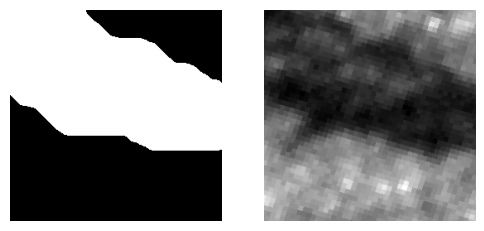

In [11]:
mask_cropped = fragment_id.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment_id.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [12]:
del fragment_id, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4073

### Dataloaders

In [13]:
class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment_id in fragments:
            H, W = FRAGMENTS_SHAPE[fragment_id]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    self.xys.append((fragment_id, x, y, W, H))
        
    def __getitem__(self, i):
        fragment_id, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-32 if x1 != 0 else 0, 32)
        y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, z1, z2)
        mask_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]        
        
        performed = A.Compose([
            A.HorizontalFlip(p=0.3), # 水平方向に反転
            A.VerticalFlip(p=0.3), # 水平方向に反転
            A.RandomRotate90(p=0.3),
            A.ShiftScaleRotate(p=0.3),
        ])(image=frag_crop, mask=mask_crop)
        frag_crop = performed["image"]
        mask_crop = performed["mask"]
        
        mean, std = ALL_MEAN_STD[fragment_id]
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).permute((2, 0, 1))
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [14]:
ALL_MEAN_STD

{'1': (array([14356.52181557, 14520.70614609, 14744.43771524, 15033.27008516,
         15378.83713455, 15754.16016986, 16109.72300626, 16369.52307949,
         16438.31554409, 16222.07887619, 15666.64744985, 14798.68459147,
         13742.24110022, 12686.91996523, 11817.69218949, 11249.06236971,
         11000.9214373 , 11017.81404872, 11208.47682255, 11483.19329296,
         11775.4475447 , 12046.20032748, 12277.60994428, 12465.56357149]),
  array([2114.49032441, 2139.82500352, 2178.50033502, 2233.26290293,
         2302.01975169, 2376.20206417, 2441.80821036, 2483.70993246,
         2488.44506847, 2445.05180237, 2346.44990857, 2193.31216295,
         2006.46319592, 1840.02783395, 1753.62156347, 1741.95262973,
         1741.04684181, 1719.55030132, 1695.41639142, 1688.92260226,
         1702.2708261 , 1728.33221695, 1758.95367666, 1789.17381258])),
 '2': (array([14356.52181557, 14520.70614609, 14744.43771524, 15033.27008516,
         15378.83713455, 15754.16016986, 16109.72300626, 163

In [15]:
class VesuviusVal(Dataset):
    def __init__(self, fragment_id):
        self.fragment_id = fragment_id
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment_id]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, z1, z2)
        
        mask_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, key="truth")

        mean, std = ALL_MEAN_STD[self.fragment_id]
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [16]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [17]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=MODEL_DEPTH):
        super().__init__()
        self.encoder = generate_model(model_depth=MODEL_DEPTH, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
   
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=SegModel()
        weight_path = "r3d18_K_200ep.pth"
        if os.path.exists(weight_path):
            self.encoder.load_pretrained_weights(torch.load(weight_path)["state_dict"])

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

In [18]:
model = CustomModel()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

### Competition metric (F0.5 Score)

In [19]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [20]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.005, patience=2, min_lr=5e-5)

In [21]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [22]:
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))    
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    scheduler.step(metrics=mloss_val)
    
    for threshold in np.arange(0.2, 0.65, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet{MODEL_DEPTH}_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

Epoch 1/20  Mem : 6.77GB      0.0001  Loss: 0.5076: 100%|██████████| 84/84 [00:30<00:00,  2.73it/s]
Val Loss: 0.4262: 100%|██████████| 24/24 [00:04<00:00,  5.20it/s]

Threshold : 0.20	FBeta : 0.134405
Threshold : 0.25	FBeta : 0.207117
Threshold : 0.30	FBeta : 0.227708
Threshold : 0.35	FBeta : 0.257658
Threshold : 0.40	FBeta : 0.268834
Threshold : 0.45	FBeta : 0.073817
Threshold : 0.50	FBeta : 0.008101
Threshold : 0.55	FBeta : 0.000003
Threshold : 0.60	FBeta : 0.000000



Epoch 2/20  Mem : 8.43GB      0.0001  Loss: 0.4192: 100%|██████████| 84/84 [00:27<00:00,  3.01it/s]
Val Loss: 0.3697: 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]

Threshold : 0.20	FBeta : 0.219341
Threshold : 0.25	FBeta : 0.241238
Threshold : 0.30	FBeta : 0.289765
Threshold : 0.35	FBeta : 0.340883
Threshold : 0.40	FBeta : 0.387281
Threshold : 0.45	FBeta : 0.382061
Threshold : 0.50	FBeta : 0.298820
Threshold : 0.55	FBeta : 0.109143
Threshold : 0.60	FBeta : 0.002917



Epoch 3/20  Mem : 8.43GB      0.0001  Loss: 0.3898: 100%|██████████| 84/84 [00:28<00:00,  2.96it/s]
Val Loss: 0.3546: 100%|██████████| 24/24 [00:05<00:00,  4.73it/s]

Threshold : 0.20	FBeta : 0.226581
Threshold : 0.25	FBeta : 0.254299
Threshold : 0.30	FBeta : 0.259193
Threshold : 0.35	FBeta : 0.083562
Threshold : 0.40	FBeta : 0.003169
Threshold : 0.45	FBeta : 0.000001
Threshold : 0.50	FBeta : 0.000000
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000



Epoch 4/20  Mem : 8.43GB      0.0001  Loss: 0.3635: 100%|██████████| 84/84 [00:28<00:00,  2.94it/s]
Val Loss: 0.3299: 100%|██████████| 24/24 [00:04<00:00,  4.82it/s]


Threshold : 0.20	FBeta : 0.246544
Threshold : 0.25	FBeta : 0.285368
Threshold : 0.30	FBeta : 0.324823
Threshold : 0.35	FBeta : 0.357241
Threshold : 0.40	FBeta : 0.376400
Threshold : 0.45	FBeta : 0.387706
Threshold : 0.50	FBeta : 0.359515
Threshold : 0.55	FBeta : 0.019124
Threshold : 0.60	FBeta : 0.000000


Epoch 5/20  Mem : 8.43GB      0.0001  Loss: 0.3425: 100%|██████████| 84/84 [00:28<00:00,  2.94it/s]
Val Loss: 0.3219: 100%|██████████| 24/24 [00:04<00:00,  4.99it/s]


Threshold : 0.20	FBeta : 0.241518
Threshold : 0.25	FBeta : 0.263982
Threshold : 0.30	FBeta : 0.291108
Threshold : 0.35	FBeta : 0.321369
Threshold : 0.40	FBeta : 0.361079
Threshold : 0.45	FBeta : 0.393563
Threshold : 0.50	FBeta : 0.406320
Threshold : 0.55	FBeta : 0.278365
Threshold : 0.60	FBeta : 0.004053


Epoch 6/20  Mem : 8.43GB      0.0001  Loss: 0.3269: 100%|██████████| 84/84 [00:28<00:00,  2.94it/s]
Val Loss: 0.3081: 100%|██████████| 24/24 [00:04<00:00,  4.82it/s]

Threshold : 0.20	FBeta : 0.252121
Threshold : 0.25	FBeta : 0.277706
Threshold : 0.30	FBeta : 0.314813
Threshold : 0.35	FBeta : 0.348637
Threshold : 0.40	FBeta : 0.375390
Threshold : 0.45	FBeta : 0.361356
Threshold : 0.50	FBeta : 0.265062
Threshold : 0.55	FBeta : 0.076437
Threshold : 0.60	FBeta : 0.000000



Epoch 7/20  Mem : 8.43GB      0.0001  Loss: 0.3129: 100%|██████████| 84/84 [00:28<00:00,  2.93it/s]
Val Loss: 0.2856: 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]

Threshold : 0.20	FBeta : 0.302644
Threshold : 0.25	FBeta : 0.353301
Threshold : 0.30	FBeta : 0.401217
Threshold : 0.35	FBeta : 0.435156
Threshold : 0.40	FBeta : 0.446149
Threshold : 0.45	FBeta : 0.437111
Threshold : 0.50	FBeta : 0.407156
Threshold : 0.55	FBeta : 0.351332
Threshold : 0.60	FBeta : 0.226154



Epoch 8/20  Mem : 8.43GB      0.0001  Loss: 0.2983: 100%|██████████| 84/84 [00:28<00:00,  2.95it/s]
Val Loss: 0.2769: 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]

Threshold : 0.20	FBeta : 0.300071
Threshold : 0.25	FBeta : 0.329340
Threshold : 0.30	FBeta : 0.357577
Threshold : 0.35	FBeta : 0.385974
Threshold : 0.40	FBeta : 0.409723
Threshold : 0.45	FBeta : 0.430072
Threshold : 0.50	FBeta : 0.442369
Threshold : 0.55	FBeta : 0.448598
Threshold : 0.60	FBeta : 0.431477



Epoch 9/20  Mem : 8.43GB      0.0001  Loss: 0.2899: 100%|██████████| 84/84 [00:28<00:00,  2.95it/s]
Val Loss: 0.2561: 100%|██████████| 24/24 [00:04<00:00,  4.88it/s]

Threshold : 0.20	FBeta : 0.385465
Threshold : 0.25	FBeta : 0.420936
Threshold : 0.30	FBeta : 0.450785
Threshold : 0.35	FBeta : 0.471634
Threshold : 0.40	FBeta : 0.484198
Threshold : 0.45	FBeta : 0.492593
Threshold : 0.50	FBeta : 0.497689
Threshold : 0.55	FBeta : 0.500891
Threshold : 0.60	FBeta : 0.497462



Epoch 10/20  Mem : 8.43GB      0.0001  Loss: 0.2824: 100%|██████████| 84/84 [00:28<00:00,  2.96it/s]
Val Loss: 0.3701: 100%|██████████| 24/24 [00:04<00:00,  4.81it/s]


Threshold : 0.20	FBeta : 0.263811
Threshold : 0.25	FBeta : 0.273908
Threshold : 0.30	FBeta : 0.285747
Threshold : 0.35	FBeta : 0.297977
Threshold : 0.40	FBeta : 0.310188
Threshold : 0.45	FBeta : 0.322649
Threshold : 0.50	FBeta : 0.337566
Threshold : 0.55	FBeta : 0.356725
Threshold : 0.60	FBeta : 0.383193


Epoch 11/20  Mem : 8.43GB      0.0001  Loss: 0.2715: 100%|██████████| 84/84 [00:28<00:00,  2.96it/s]
Val Loss: 0.2499: 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]


Threshold : 0.20	FBeta : 0.464750
Threshold : 0.25	FBeta : 0.489210
Threshold : 0.30	FBeta : 0.504183
Threshold : 0.35	FBeta : 0.509850
Threshold : 0.40	FBeta : 0.511550
Threshold : 0.45	FBeta : 0.511828
Threshold : 0.50	FBeta : 0.510020
Threshold : 0.55	FBeta : 0.503800
Threshold : 0.60	FBeta : 0.488797


Epoch 12/20  Mem : 8.43GB      0.0001  Loss: 0.2657: 100%|██████████| 84/84 [00:28<00:00,  2.97it/s]
Val Loss: 0.2547: 100%|██████████| 24/24 [00:04<00:00,  4.94it/s]


Threshold : 0.20	FBeta : 0.424372
Threshold : 0.25	FBeta : 0.444540
Threshold : 0.30	FBeta : 0.458938
Threshold : 0.35	FBeta : 0.468087
Threshold : 0.40	FBeta : 0.471795
Threshold : 0.45	FBeta : 0.475244
Threshold : 0.50	FBeta : 0.475639
Threshold : 0.55	FBeta : 0.472706
Threshold : 0.60	FBeta : 0.463118


Epoch 13/20  Mem : 8.43GB      0.0001  Loss: 0.2564: 100%|██████████| 84/84 [00:28<00:00,  2.95it/s]
Val Loss: 0.3500: 100%|██████████| 24/24 [00:04<00:00,  4.81it/s]


Threshold : 0.20	FBeta : 0.308794
Threshold : 0.25	FBeta : 0.326045
Threshold : 0.30	FBeta : 0.340545
Threshold : 0.35	FBeta : 0.353602
Threshold : 0.40	FBeta : 0.365643
Threshold : 0.45	FBeta : 0.378079
Threshold : 0.50	FBeta : 0.391163
Threshold : 0.55	FBeta : 0.406003
Threshold : 0.60	FBeta : 0.422699


Epoch 14/20  Mem : 8.43GB      0.0001  Loss: 0.2569: 100%|██████████| 84/84 [00:28<00:00,  2.95it/s]
Val Loss: 0.3195: 100%|██████████| 24/24 [00:04<00:00,  4.88it/s]


Threshold : 0.20	FBeta : 0.287197
Threshold : 0.25	FBeta : 0.306037
Threshold : 0.30	FBeta : 0.326204
Threshold : 0.35	FBeta : 0.344651
Threshold : 0.40	FBeta : 0.362558
Threshold : 0.45	FBeta : 0.384427
Threshold : 0.50	FBeta : 0.407806
Threshold : 0.55	FBeta : 0.432239
Threshold : 0.60	FBeta : 0.457862


Epoch 15/20  Mem : 8.43GB       5e-05  Loss: 0.2434: 100%|██████████| 84/84 [00:28<00:00,  2.96it/s]
Val Loss: 0.2502: 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]


Threshold : 0.20	FBeta : 0.507525
Threshold : 0.25	FBeta : 0.521578
Threshold : 0.30	FBeta : 0.528406
Threshold : 0.35	FBeta : 0.519117
Threshold : 0.40	FBeta : 0.498182
Threshold : 0.45	FBeta : 0.466345
Threshold : 0.50	FBeta : 0.429473
Threshold : 0.55	FBeta : 0.387685
Threshold : 0.60	FBeta : 0.340597


Epoch 16/20  Mem : 8.43GB       5e-05  Loss: 0.2355: 100%|██████████| 84/84 [00:28<00:00,  2.98it/s]
Val Loss: 0.2345: 100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


Threshold : 0.20	FBeta : 0.470740
Threshold : 0.25	FBeta : 0.499528
Threshold : 0.30	FBeta : 0.514243
Threshold : 0.35	FBeta : 0.521363
Threshold : 0.40	FBeta : 0.527038
Threshold : 0.45	FBeta : 0.532259
Threshold : 0.50	FBeta : 0.537925
Threshold : 0.55	FBeta : 0.540822
Threshold : 0.60	FBeta : 0.538935


Epoch 17/20  Mem : 8.43GB       5e-05  Loss: 0.2332: 100%|██████████| 84/84 [00:28<00:00,  2.95it/s]
Val Loss: 0.3568: 100%|██████████| 24/24 [00:04<00:00,  4.86it/s]


Threshold : 0.20	FBeta : 0.278156
Threshold : 0.25	FBeta : 0.292314
Threshold : 0.30	FBeta : 0.306946
Threshold : 0.35	FBeta : 0.321682
Threshold : 0.40	FBeta : 0.336902
Threshold : 0.45	FBeta : 0.353719
Threshold : 0.50	FBeta : 0.371780
Threshold : 0.55	FBeta : 0.390724
Threshold : 0.60	FBeta : 0.410826


Epoch 18/20  Mem : 8.43GB       5e-05  Loss: 0.2348: 100%|██████████| 84/84 [00:28<00:00,  2.96it/s]
Val Loss: 0.2381: 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


Threshold : 0.20	FBeta : 0.395520
Threshold : 0.25	FBeta : 0.426588
Threshold : 0.30	FBeta : 0.452009
Threshold : 0.35	FBeta : 0.476718
Threshold : 0.40	FBeta : 0.496494
Threshold : 0.45	FBeta : 0.512231
Threshold : 0.50	FBeta : 0.524152
Threshold : 0.55	FBeta : 0.532987
Threshold : 0.60	FBeta : 0.538067


Epoch 19/20  Mem : 8.43GB       5e-05  Loss: 0.2288: 100%|██████████| 84/84 [00:28<00:00,  2.97it/s]
Val Loss: 0.2235: 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]


Threshold : 0.20	FBeta : 0.489193
Threshold : 0.25	FBeta : 0.517615
Threshold : 0.30	FBeta : 0.538625
Threshold : 0.35	FBeta : 0.551381
Threshold : 0.40	FBeta : 0.561204
Threshold : 0.45	FBeta : 0.568513
Threshold : 0.50	FBeta : 0.570165
Threshold : 0.55	FBeta : 0.571011
Threshold : 0.60	FBeta : 0.569582


Epoch 20/20  Mem : 8.43GB       5e-05  Loss: 0.2270: 100%|██████████| 84/84 [00:28<00:00,  2.95it/s]
Val Loss: 0.2451: 100%|██████████| 24/24 [00:05<00:00,  4.80it/s]


Threshold : 0.20	FBeta : 0.356070
Threshold : 0.25	FBeta : 0.386629
Threshold : 0.30	FBeta : 0.415883
Threshold : 0.35	FBeta : 0.442889
Threshold : 0.40	FBeta : 0.468200
Threshold : 0.45	FBeta : 0.491595
Threshold : 0.50	FBeta : 0.511645
Threshold : 0.55	FBeta : 0.527762
Threshold : 0.60	FBeta : 0.539771
